In [1]:
import requests
import json
import os
from urllib.request import urlretrieve
import zipfile
import glob
import pandas as pd
import re
from memory_profiler import memory_usage
import pyarrow.dataset as ds
import pyarrow.feather as feather
import pyarrow.parquet as pq
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext rpy2.ipython
%load_ext memory_profiler

### Download and unzip the data

In [3]:
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figsharerainfall/"

In [4]:
%%time
%memit
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

peak memory: 202.59 MiB, increment: 0.15 MiB
CPU times: user 72.4 ms, sys: 39.7 ms, total: 112 ms
Wall time: 3.16 s


[{'is_link_only': False,
  'name': 'daily_rainfall_2014.png',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'id': 26579150,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'size': 58863},
 {'is_link_only': False,
  'name': 'environment.yml',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'id': 26579171,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'size': 192},
 {'is_link_only': False,
  'name': 'README.md',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'id': 26586554,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'size': 5422},
 {'is_link_only': False,
  'name': 'data.zip',
  'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'id': 26766812,
  'download_url': 'https://

In [5]:
%%time
%memit
files_to_dl = ["data.zip"] 
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

peak memory: 204.73 MiB, increment: 0.06 MiB
CPU times: user 2.26 s, sys: 1.91 s, total: 4.17 s
Wall time: 1min


In [6]:
%%time
%memit
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

peak memory: 205.74 MiB, increment: 0.00 MiB
CPU times: user 14.1 s, sys: 2.11 s, total: 16.2 s
Wall time: 18.5 s


### Combining data CSVs

In [7]:
%%time
%memit

files = glob.glob('figsharerainfall/*.csv')

df = pd.concat((pd.read_csv(file, header=0, index_col=0)
                .assign(model=re.search(r'/(.*)_d', file)[1])
                for file in files))

df.to_csv("figsharerainfall/combined_data.csv")

peak memory: 206.42 MiB, increment: 0.00 MiB
CPU times: user 5min 2s, sys: 11.1 s, total: 5min 13s
Wall time: 5min 16s


### Load the combined CSV to memory

In [8]:
%%time
%%memit
df_float64 = pd.read_csv("figsharerainfall/combined_data.csv")

peak memory: 9127.97 MiB, increment: 5474.65 MiB
CPU times: user 49.7 s, sys: 9.57 s, total: 59.3 s
Wall time: 1min 1s


#### Changing `dtype` of data

In [9]:
df_float32 = df.astype('float32', errors='ignore')

In [10]:
print(f"Memory usage with float64: {df_float64.memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df_float32.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 3500.78 MB
Memory usage with float32: 2250.50 MB


#### Using Dask

In [11]:
%%time
%%memit
ddf = dd.read_csv('figsharerainfall/combined_data.csv', blocksize=25e6)

peak memory: 8455.70 MiB, increment: -18.40 MiB
CPU times: user 103 ms, sys: 185 ms, total: 288 ms
Wall time: 1.58 s


In [12]:
cols = ['lat_min', 'lat_max', 'lon_min', 'lon_max', 'rain (mm/day)']
ddf[cols] = ddf[cols].astype('float32')

## EDA

### Value Counts of `model`:

#### Pandas DataFrame:

In [13]:
%%time
%%memit
print(df_float32[["model"]].value_counts())

model           
MPI-ESM1-2-HR       5154240
TaiESM1             3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
NorESM2-MM          3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
NorESM2-LM           919800
CanESM5              551880
BCC-ESM1             551880
observed              46020
dtype: int64
peak memory: 8455.50 MiB, increment: 0.01 MiB
CPU times: user 4.54 s, sys: 2.23 s, total: 6.77 s
Wall time: 7.58 s


#### Dask DataFrame:

In [14]:
%%time
%%memit
print(ddf["model"].value_counts().compute())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
NorESM2-MM          3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
NorESM2-LM           919800
CanESM5              551880
BCC-ESM1             551880
observed              46020
Name: model, dtype: int64
peak memory: 7997.93 MiB, increment: 1130.60 MiB
CPU times: user 1min 26s, sys: 25.5 s, total: 1min 52s
Wall time: 40.3 s


#### Observations:

|                  | Peak Memory | CPU Time | Wall Time |
|:----------------:|:-----------:|:--------:|:---------:|
| Pandas DataFrame |8455.50 MB  |  6.77s     |   7.58s        |
|  Dask DataFrame  | 7997.93 MB |1min 53s     | 40s          |

When calling `value_counts` function:
- By using Dask DataFrame over Pandas DataFrame, we see that the peak memory drops by a considerable amount
- However, the CPU and Wall Times are quite a bit higher when using Dask DataFrame over Pandas DataFrame

### Summary statistics of Rainfall (mm/day) across Australia:

#### Pandas DataFrame `float64`:

In [15]:
%%time
%%memit
print(df_float64[['rain (mm/day)']].describe())

       rain (mm/day)
count   5.929456e+07
mean    1.901827e+00
std     5.588275e+00
min    -3.807373e-12
25%     3.876672e-06
50%     6.161705e-02
75%     1.021314e+00
max     4.329395e+02
peak memory: 7312.34 MiB, increment: 2292.99 MiB
CPU times: user 3.63 s, sys: 2.54 s, total: 6.18 s
Wall time: 7.4 s


#### Pandas DataFrame `float32`:

In [16]:
%%time
%%memit
print(df_float32[['rain (mm/day)']].describe())

       rain (mm/day)
count   5.929456e+07
mean    1.901828e+00
std     5.588274e+00
min    -3.807373e-12
25%     3.876672e-06
50%     6.161705e-02
75%     1.021314e+00
max     4.329395e+02
peak memory: 6648.28 MiB, increment: 1428.35 MiB
CPU times: user 2.55 s, sys: 958 ms, total: 3.51 s
Wall time: 4.13 s


#### Dask DataFrame `float32`:

In [17]:
%%time
%%memit
print(ddf[['rain (mm/day)']].describe().compute())

       rain (mm/day)
count   5.929456e+07
mean    1.901827e+00
std     5.588275e+00
min    -3.807373e-12
25%     5.371856e-03
50%     3.320863e-01
75%     3.030826e+00
max     4.329395e+02
peak memory: 6823.99 MiB, increment: 1368.04 MiB
CPU times: user 1min 34s, sys: 33.7 s, total: 2min 8s
Wall time: 40.4 s


#### Observations:

|                            | Peak Memory | CPU Time | Wall Time |
|:--------------------------:|:-----------:|:--------:|:---------:|
| Pandas DataFrame `float64` |  7312.34 MB           | 6.18s         |  7.4s         |
| Pandas DataFrame `float32` |  6648.28 MB           |   3.51s       | 4.13s          |
|  Dask DataFrame `float32`  |   6823.99 MB          |   2min 8s      |  40.4s         |

When calling the `describe` function:
- The Peak Memory consumed is drops when using the Pandas DataFrame with `float32` numeric columns over the Pandas DataFrame with `float64` numeric columns
- The CPU and Wall Times also drop when switching from the Pandas DataFrame with `float64` to the Pandas DataFrame with `float32` numeric columns
- Interestingly, when compared with the Pandas DataFrame with `float32` numeric columns, the Dask DataFrame with `float32` numeric columns consumes more Peak Memory, and also has much higher CPU and Wall Times

### BoxPlot of Rainfall (mm/day) across Australia

In [18]:
sns.set_theme(style="whitegrid")
sns.set(rc={"figure.figsize": (15, 7.5)}, font_scale=1.25)

#### Pandas DataFrame `float64`:

peak memory: 6133.25 MiB, increment: 1457.97 MiB
CPU times: user 2.36 s, sys: 644 ms, total: 3 s
Wall time: 3.65 s


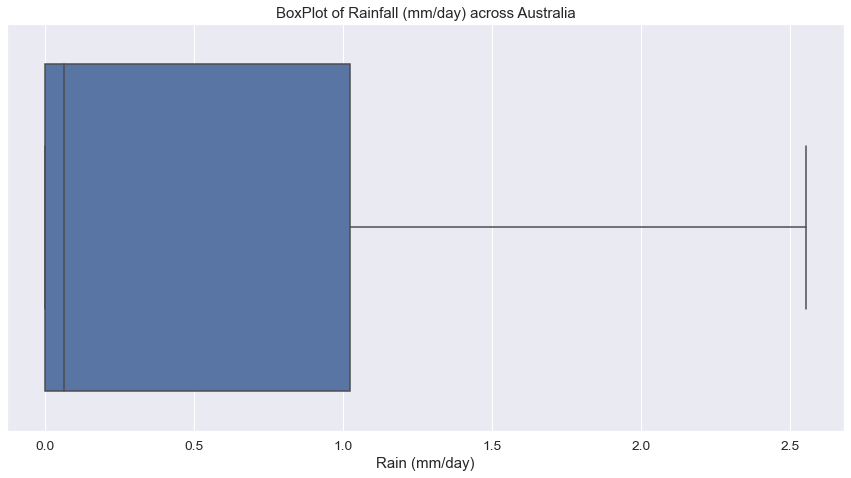

In [19]:
%%time
%%memit
sns.boxplot(x=df_float64['rain (mm/day)'], showfliers=False);
plt.title("BoxPlot of Rainfall (mm/day) across Australia");
plt.xlabel("Rain (mm/day)");

#### Pandas DataFrame `float32`:

peak memory: 5527.03 MiB, increment: 643.94 MiB
CPU times: user 1.85 s, sys: 333 ms, total: 2.19 s
Wall time: 2.62 s


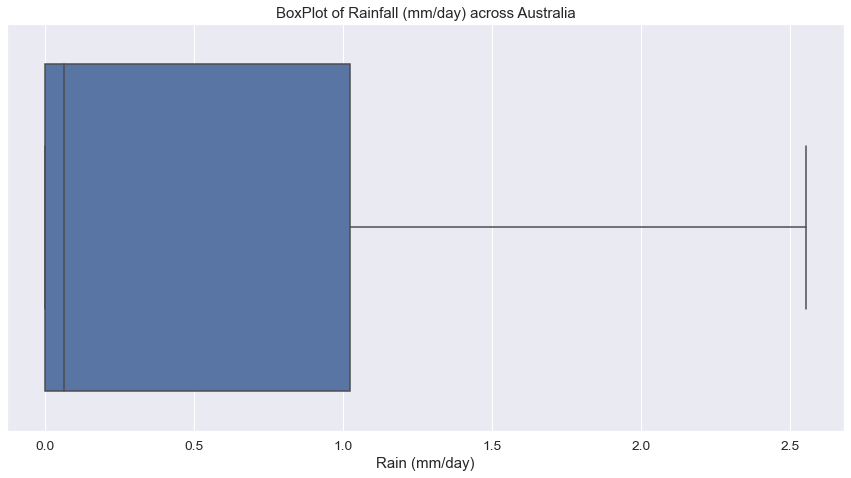

In [20]:
%%time
%%memit
sns.boxplot(x=df_float32['rain (mm/day)'], showfliers=False);
plt.title("BoxPlot of Rainfall (mm/day) across Australia");
plt.xlabel("Rain (mm/day)");

#### Dask DataFrame `float32`:

peak memory: 6617.09 MiB, increment: 1805.34 MiB
CPU times: user 4min 22s, sys: 1min 22s, total: 5min 45s
Wall time: 1min 53s


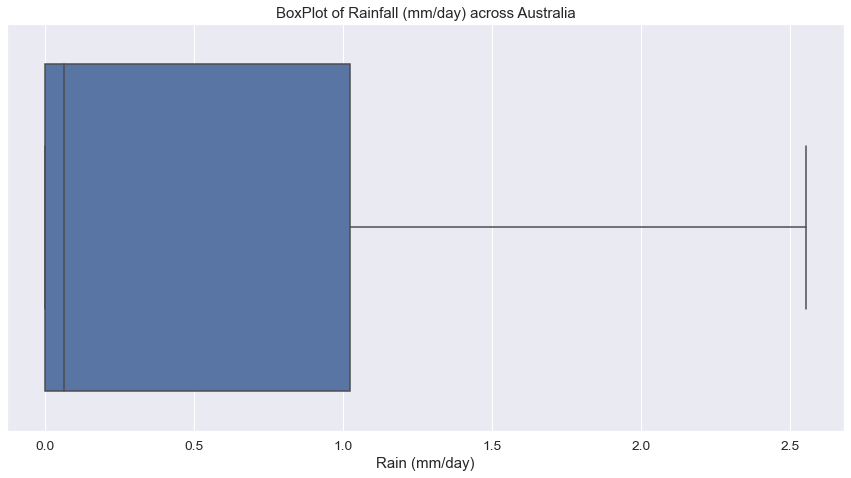

In [21]:
%%time
%%memit
sns.boxplot(x=ddf['rain (mm/day)'], showfliers=False);
plt.title("BoxPlot of Rainfall (mm/day) across Australia");
plt.xlabel("Rain (mm/day)");

#### Observations:

|                            | Peak Memory | CPU Time | Wall Time |
|:--------------------------:|:-----------:|:--------:|:---------:|
| Pandas DataFrame `float64` |  6133.25 MB           | 3s         |   3.65s        |
| Pandas DataFrame `float32` |  5527.03 MB           |  2.19s        |   2.62s        |
|  Dask DataFrame `float32`  |  6617.09 MB           |  5min 45s        |  1min 53s         |


When creating boxplots using `sns.boxplot`:
- The Peak Memory consumed is lower when using the Pandas DataFrame with `float32` numeric columns when compared with using the Pandas DataFrame with `float64` numeric columns
- The CPU and Wall Times are also lower when using the Pandas DataFrame with `float32` numeric columns when compared with using the Pandas DataFrame with `float64` numeric columns
- Interestingly, the Dask DataFrame with `float32` numeric columns consumes the most amount of Peak Memory and also has much higher CPU and Wall times when compared with the Panadas DataFrames